# Packages Installs, imports, and presets

In [203]:
#from scapy.all import *
import pandas as pd
#import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from collections import defaultdict
import os
from transformers import MobileViTV2Model
import torch
import torchmetrics
from torch import optim
import lightning as L
import torch
import torch.nn as nn

In [204]:
INPUT_SIZE = (256,256,3)

# Data preprocessing

In [205]:
def get_attack_directory_attack(path):
  return path[29:]
attacks_directories= [
                      '20200425_UOWM_IEC104_Dataset_m_sp_na_1_DoS',
                      '20200426_UOWM_IEC104_Dataset_c_ci_na_1',
                      '20200427_UOWM_IEC104_Dataset_c_se_na_1',
                      '20200428_UOWM_IEC104_Dataset_c_sc_na_1',
                      '20200605_UOWM_IEC104_Dataset_c_rd_na_1',
                      '20200606_UOWM_IEC104_Dataset_c_rp_na_1',
                      '20200426_UOWM_IEC104_Dataset_c_ci_na_1_DoS',
                      '20200605_UOWM_IEC104_Dataset_c_rd_na_1_DoS',
                      '20200606_UOWM_IEC104_Dataset_c_rp_na_1_DoS',
                      '20200428_UOWM_IEC104_Dataset_c_se_na_1_DoS',
                      '20200429_UOWM_IEC104_Dataset_c_sc_na_1_DoS',
                                            # '20200608_UOWM_IEC104_Dataset_mitm_drop'
                                            ]
get_attack_directory_attack(attacks_directories[0])

'm_sp_na_1_DoS'

In [206]:
df =pd.concat([pd.read_parquet(f"./data/{attack_directory}.parquet") for attack_directory in attacks_directories ])

In [207]:
indexes = df.index.unique()

In [208]:
renames= {}
for index in tqdm(indexes):
    split_index = index.split('_')
    # print(index)
    src_ip = split_index[0]
    dst_ip = split_index[1]
    src_prt = split_index[2]
    dst_prt = split_index[3]
    
    reverse_index="_".join([dst_ip,src_ip,dst_prt,src_prt])+"_TCP"+index.split('TCP')[1]
    if not (index in renames):
        renames[reverse_index]= index
        # renames[index]= index
    # print()
    # df= df.rename(index={name:index})
    # break

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26660/26660 [00:00<00:00, 525085.67it/s]


In [209]:
df.index.nunique()

26660

In [210]:
df.rename(index=renames).index.nunique()

13330

In [211]:
df = df.rename(index=renames)

In [212]:
df.shape

(518377, 1667)

In [213]:
df.index.nunique()

13330

In [214]:
df.groupby('flow')['tv_sec'].count().mean()

38.887996999249815

In [215]:
df.filter(regex='fin.*',axis=1)

,tcp_fin_0
flow,
192.168.1.20_192.168.1.21_50045_2404_TCP_m_sp_na_1_DoS,0
192.168.1.20_192.168.1.21_50045_2404_TCP_m_sp_na_1_DoS,0
192.168.1.20_192.168.1.21_50045_2404_TCP_m_sp_na_1_DoS,0
192.168.1.20_192.168.1.21_50045_2404_TCP_m_sp_na_1_DoS,0
192.168.1.20_192.168.1.21_50045_2404_TCP_m_sp_na_1_DoS,0
...,...
192.168.1.29_192.168.1.13_40651_2404_TCP_c_sc_na_1_DoS,0
192.168.1.29_192.168.1.22_39973_2404_TCP_c_sc_na_1_DoS,0
192.168.1.29_192.168.1.22_39973_2404_TCP_c_sc_na_1_DoS,0


In [216]:
df['tcp_fin_0'].sum()

0

In [218]:
%%time
from tqdm import tqdm
from collections import defaultdict
df=df.sort_values(by=['flow','tv_sec','tv_usec'],axis=0,ascending=True)

TIMEOUT = 30

last_timestamp = defaultdict(lambda: 0)
flow_bin = defaultdict(lambda: 0)
splits = []
for flow_id,r in tqdm(df.iterrows()):
  # flow_id = c/
  if (r['tv_sec'] - last_timestamp[flow_id]) >= TIMEOUT:# in the first packet of a flow it's always true
    flow_bin[flow_id] += 1
  splits.append(f"{flow_bin[flow_id]}_{flow_id}")
  last_timestamp[flow_id] = r['tv_sec']
  # if r['tcp_fin_0'] == 1:
  #   flow_bin[flow_id] += 1
df['flow'] = splits
# df.reindex(splits)
del splits
df=df.set_index('flow')

518377it [00:48, 10722.86it/s]


CPU times: user 45.3 s, sys: 13 s, total: 58.3 s
Wall time: 54.1 s


In [219]:
df.groupby('flow')['tv_usec'].count().mean()

38.24813694385007

In [220]:
tmp=df.groupby('flow')['tv_sec'].count().value_counts()

In [221]:
tmp=df.groupby('flow')['tv_sec'].count().value_counts()
tmp=tmp.sort_index().cumsum()
# tmp = tmp/tmp.max()
tmp

tv_sec
2            8
3            9
4           11
5           12
6           68
         ...  
9579     13549
25497    13550
25537    13551
26601    13552
27265    13553
Name: count, Length: 141, dtype: int64

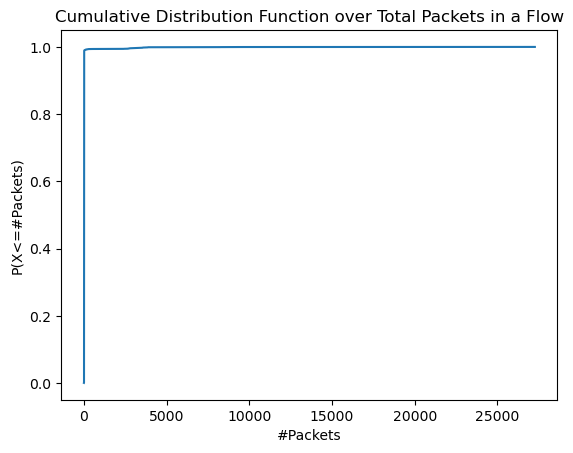

In [222]:
tmp=df.groupby('flow')['tv_sec'].count().value_counts()
tmp=tmp.sort_index().cumsum()
tmp = tmp/tmp.max()
# tmp.sort_values()
# tmp.index = tmp.index.map(np.log10)
def plot_cdf(x):
  plt.title('Cumulative Distribution Function over Total Packets in a Flow')
  plt.xlabel("#Packets")
  plt.ylabel(r"P(X<=#Packets)")
  # print(x)
  plt.plot(x)
plot_cdf(tmp)

In [223]:
df.index.nunique()

13553

In [224]:
df.to_parquet(f'data/iec104.parquet')